## <p style="text-align: center">Assignment - 3 </p>

<b>Task 1: Handle Missing Values and Remove Outliers</b>
- Load the "Apple Adjusted Close Price" dataset into your preferred programming environment.
- Check for any missing values in the dataset and handle them appropriately (e.g., interpolation, filling with mean/median).
- Detect and remove outliers in the dataset using the z-score method or any other suitable outlier detection technique.


In [215]:
## importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import zscore
import warnings

plt.rcParams["figure.figsize"] = [12, 5]

In [155]:
## importing dataset
import yfinance as yf
dataset = yf.download('AAPL')

[*********************100%***********************]  1 of 1 completed


In [156]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.128348,0.128906,0.128348,0.128348,0.099584,469033600
1980-12-15,0.122210,0.122210,0.121652,0.121652,0.094388,175884800
1980-12-16,0.113281,0.113281,0.112723,0.112723,0.087461,105728000
1980-12-17,0.115513,0.116071,0.115513,0.115513,0.089625,86441600
1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092224,73449600


In [157]:
print(dataset.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


#### No Null or missing values

In [158]:
#setting the frequency for any resampling required in future
dataset.index = pd.date_range(start='1980-12-12' ,periods=dataset.shape[0] , freq='B')
dataset.index

DatetimeIndex(['1980-12-12', '1980-12-15', '1980-12-16', '1980-12-17',
               '1980-12-18', '1980-12-19', '1980-12-22', '1980-12-23',
               '1980-12-24', '1980-12-25',
               ...
               '2021-12-29', '2021-12-30', '2021-12-31', '2022-01-03',
               '2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07',
               '2022-01-10', '2022-01-11'],
              dtype='datetime64[ns]', length=10718, freq='B')

In [159]:
# removes outliers for a specified column using Z score criterion for a given threshold
def remove_outliers(df,col,threshold=3):
    df['z_score'] = zscore(df[col])
    df = df.loc[(df['z_score']>-threshold) & (df['z_score']<threshold)]
    df = df.drop(['z_score'],axis=1)
    return df

In [268]:
for col in dataset.columns:
    dataset = remove_outliers(dataset,col,3)
dataset.head()

,Open,High,Low,Close,Adj Close,Volume
1980-12-31,0.154018,0.155134,0.154018,0.154018,0.119501,21660800.0
1981-01-31,0.123326,0.123884,0.123326,0.123326,0.095687,19152000.0
1981-02-28,0.116629,0.116629,0.116071,0.116071,0.090058,13708800.0
1981-03-31,0.118304,0.118862,0.118304,0.118304,0.091791,16486400.0
1981-04-30,0.122768,0.122768,0.122210,0.122210,0.094821,18950400.0


<b>Task 2: Decompose the Time Series</b>

- Plot the time series data to visualize the overall trend and seasonality patterns.
- Apply the seasonal decomposition of time series (e.g., using the seasonal_decompose function in Python's statsmodels library) to decompose the time series into its components: trend, seasonality, and residual.
- Plot the decomposed components and interpret the results.
- Additionally, use the Hodrick-Prescott (HP) filter to decompose the time series into trend and cyclical components.


In [161]:
# ## importing dataset
# dataset = yf.download('AAPL')


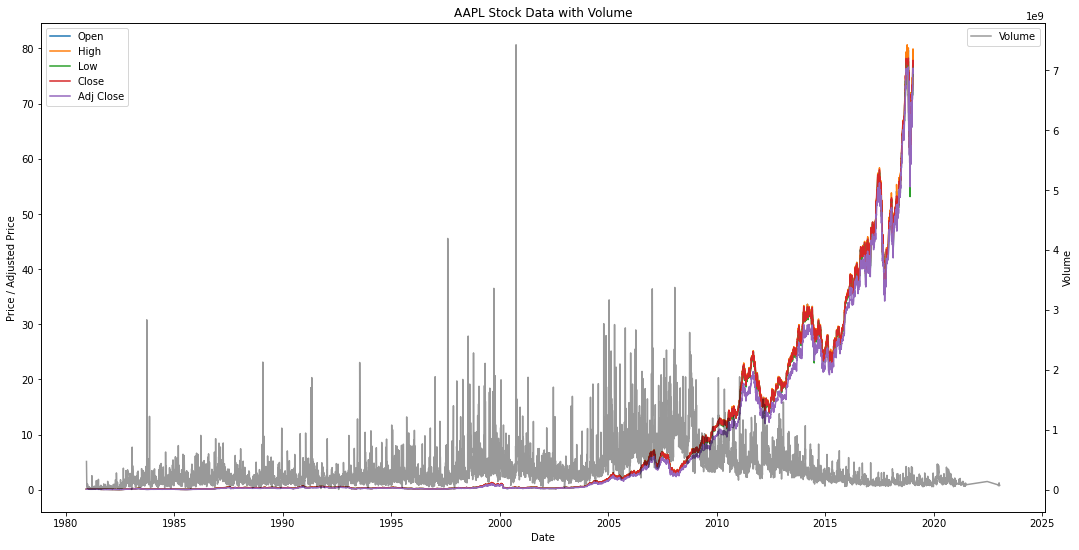

In [162]:
fig, ax1 = plt.subplots(figsize=(18,9))

df_without_volume = dataset.drop(columns=['Volume'])

for column in df_without_volume.columns:
    ax1.plot(df_without_volume.index, df_without_volume[column], label=column)
    
ax2 = ax1.twinx()
ax2.plot(df.index, df['Volume'], label='Volume', color='black', alpha=0.4)

ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.title('AAPL Stock Data with Volume')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price / Adjusted Price')
ax2.set_ylabel('Volume')

# show the plot
plt.show()

### Since stock price data depends on various factors and increses in on this type of scale hence we don't observe any clear seasonality, due to the high number of data points and the given time scale, more insights can be found after seasonal decomposition.

In [163]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [288]:
dataset = dataset.asfreq('B')

In [289]:
print(dataset.isna().sum())
dataset = dataset.ffill()

Open         8679
High         8679
Low          8679
Close        8679
Adj Close    8679
Volume       8679
dtype: int64


In [290]:
dataset = dataset.resample('M').ffill()

In [167]:
result = seasonal_decompose(dataset['Open'],model='additive')

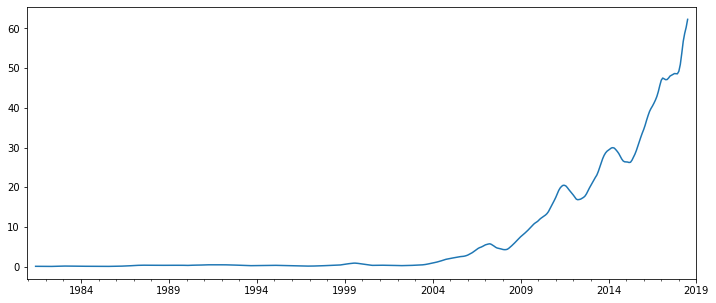

In [168]:
result.trend.plot()
plt.show()

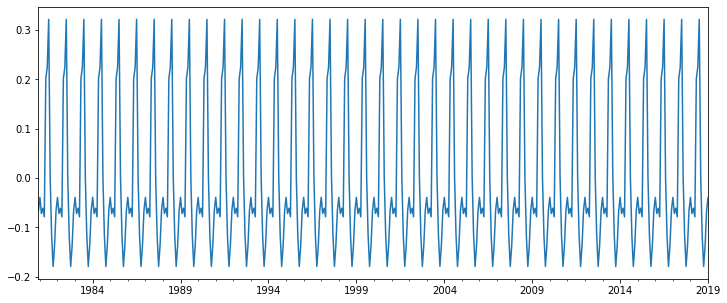

In [169]:
result.seasonal.plot()
plt.show()

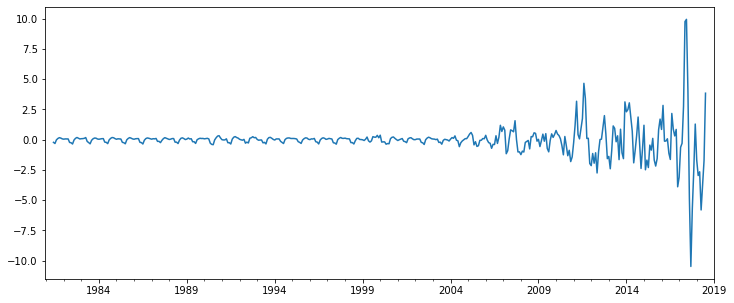

In [170]:
result.resid.plot()
plt.show()

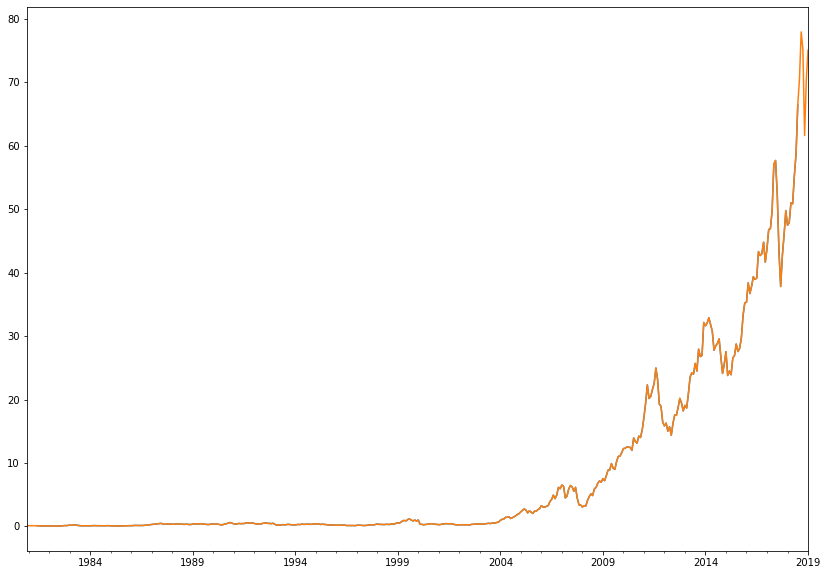

In [188]:
fig, axes = plt.subplots(figsize=(14,10))

(result.trend + result.seasonal + result.resid).plot(ax=axes)
dataset['Open'].plot(ax=axes)

plt.show()

The results from the decomposition:
- The trend observed is in upward direction.
- The seasonal component shows seasonality component with repeating pattern of highs and lows.
- The residual component shows a repetitive pattern initally but ending up with a random variation

In [171]:
from statsmodels.tsa.filters.hp_filter import hpfilter

In [174]:
cyclic, trend = hpfilter(dataset['Open'])

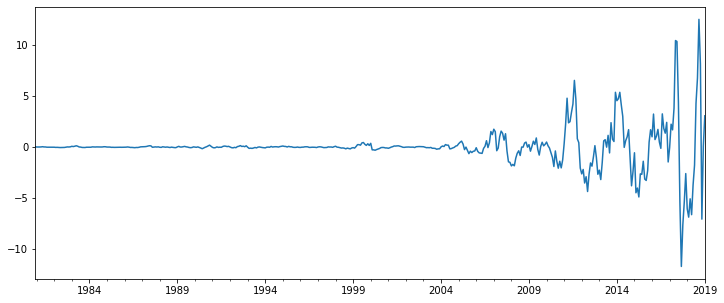

In [177]:
cyclic.plot()
plt.show()

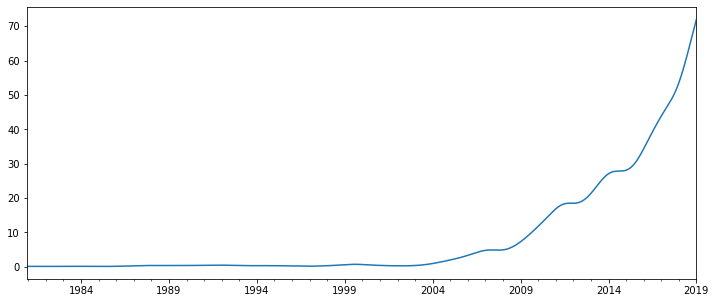

In [178]:
trend.plot()
plt.show()

In [181]:
(((cyclic + trend) == dataset['Open']).sum() == dataset.shape[0])

True

#### Task 3: Check for Stationarity

- Perform both the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test on the original time series data.
- Interpret the test results to determine if the time series is stationary or not.
- Repeat the ADF and KPSS tests on the residual obtained from the decomposition and interpret the results.


In [291]:
from statsmodels.tsa.stattools import adfuller, kpss

In [292]:
def print_results(output, test='adf'):
    
    pval = output[1]
    test_score = output[0]
    lags = output[2]
    
    decision = 'Non-Stationary'
    if test == 'adf':
        critical = output[4]
        if pval < 0.05:
            decision = 'Stationary'
    elif test=='kpss':
        critical = output[3]
        if pval >= 0.05:
            decision = 'Stationary'
            
    output_dict = {
    'Test Statistic': test_score,
    'p-value': pval,
    'Numbers of lags': lags,
    'decision': decision
    }
    for key, value in critical.items():
        output_dict["Critical Value (%s)" % key] = value
       
    return pd.Series(output_dict, name=test)

In [293]:
n = dataset.shape[0]
lags = int(12*(n/100)**(0.25))

In [294]:
adf_output = adfuller(dataset['Open'])
kpss_output = kpss(dataset['Open'])

In [295]:
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)

,adf,kpss
Test Statistic,2.872774,1.905051
p-value,1.0,0.01
Numbers of lags,18,12
decision,Non-Stationary,Non-Stationary
Critical Value (1%),-3.447057,0.739
Critical Value (5%),-2.868904,0.463
Critical Value (10%),-2.570693,0.347
Critical Value (2.5%),NaN,0.574


In [296]:
residuals = result.resid.dropna()

In [297]:
adf_output_residual = adfuller(residuals)
kpss_output_residual = kpss(residuals)

In [298]:
pd.concat([
print_results(adf_output_residual, 'adf'),
print_results(kpss_output_residual, 'kpss')
], axis=1)

,adf,kpss
Test Statistic,-6.947626,0.090328
p-value,0.0,0.1
Numbers of lags,18,2
decision,Stationary,Stationary
Critical Value (1%),-3.445758,0.739
Critical Value (5%),-2.868333,0.463
Critical Value (10%),-2.570388,0.347
Critical Value (2.5%),NaN,0.574


#### Task 4: Make the Series Stationary

- Visualize the original series and the residual series after decomposition.
- Apply different methods to make the residual series and the original series stationary (e.g., differencing, logarithmic transformation).
- Compare the results visually and choose the best method for further analysis.


In [299]:
def check_stationarity(df):
    kps = kpss(df)
    adf = adfuller(df)
    
    kpss_pv, adf_pv = kps[1], adf[1]
    kpssh, adfh = 'Stationary', 'Non-stationary'
    
    if adf_pv < 0.05:
        # Reject ADF Null Hypothesis
        adfh = 'Stationary'
    if kpss_pv < 0.05:
        # Reject KPSS Null Hypothesis
        kpssh = 'Non Stationary'
    return (kpssh, adfh)

In [300]:
def plot_comparison(methods, plot_type='line'):
    n = len(methods) // 2
    fig, ax = plt.subplots(n,2, sharex=True, figsize=(20,10))
    for i, method in enumerate(methods):
        method.dropna(inplace=True)
        name = [n for n in globals() if globals()[n] is method]
        v, r = i // 2, i % 2

        kpss_s, adf_s = check_stationarity(method)

        method.plot(kind=plot_type, 
                    ax=ax[v,r], 
                    legend=False, 
                    title=f'{name[0].upper()} KPSS={kpss_s}, ADF={adf_s}')
        ax[v,r].title.set_size(14)
        method.rolling(52).mean().plot(ax=ax[v,r], legend=False)
        

In [301]:
first_ord_diff = dataset['Open'].diff().dropna()

In [302]:
second_ord_diff = dataset['Open'].diff().diff().dropna()

In [303]:
diseasonalize = dataset['Open'].diff(52).dropna()

In [304]:
rolling_mean = dataset['Open'].rolling(window=52).mean()
subt_roll_mean = dataset['Open'] - rolling_mean

In [305]:
log_transform = np.log(dataset['Open'])

In [306]:
square_root = np.sqrt(dataset['Open'])

In [307]:
decomp = seasonal_decompose(dataset['Open'])
sd_detrend = (decomp.observed - decomp.trend)

In [308]:
cyclic_extract, trend = hpfilter(dataset['Open'])

In [309]:
methods = [first_ord_diff, second_ord_diff, 
           diseasonalize, subt_roll_mean, 
           log_transform, square_root,
           sd_detrend, cyclic_extract]

In [310]:
plt.rcParams["figure.figsize"] = [12, 5]

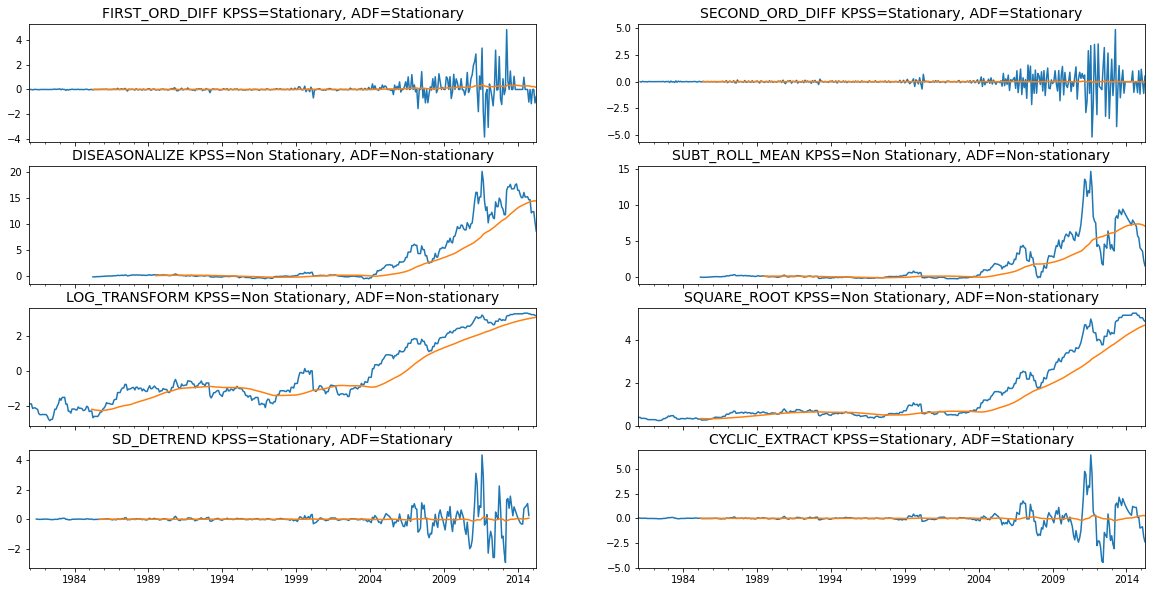

In [311]:
import warnings
plot = plot_comparison(methods)
warnings.simplefilter('ignore')

#### Task 5: Test for Normality

- Perform the Shapiro-Wilk test to test for normality of the original and transformed series.
- Plot QQ-plots to visually inspect the normality assumption.
- Interpret the test results and the QQ-plots to determine if the series can be considered normally distributed.


In [312]:
from scipy.stats import shapiro

In [313]:
def is_normal(test, p_level=0.05):
    stat, pval = test
    return 'Normal' if pval > 0.05 else 'Not Normal'

In [314]:
normal_args = (np.mean(dataset['Open']),np.std(dataset['Open']))

print(is_normal(shapiro(dataset['Open'])))

Not Normal


#### Hence not normal

In [315]:
from statsmodels.tsa.ar_model import AutoReg

model = AutoReg(dataset['Open'].dropna(), lags=1, trend='n').fit()

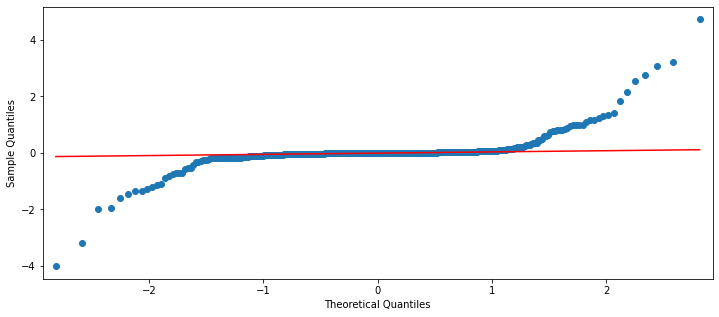

In [316]:
from statsmodels.graphics.gofplots import qqplot
qqplot(model.resid, line='q');

No This data significantly deviates from the y=x hence it is not normal

#### Task 6: Test for Homoscedasticity and Apply Box-Cox Transformation

- Test for homoscedasticity in the transformed series using appropriate statistical tests (e.g., Breusch-Pagan test).
- Apply the Box-Cox transformation to the series to normalize the data and stabilize variance.
- Visualize the transformed series and assess the improvement in homoscedasticity.

In [317]:
from statsmodels.stats.api import (het_breuschpagan, 
                                   het_white)
from statsmodels.tools.tools import add_constant

In [318]:
model.resid

1981-01-31   -0.001084
1981-02-28   -0.001084
1981-03-31   -0.036798
1981-04-30    0.003631
1981-05-31   -0.000864
                ...   
2014-12-31   -1.348266
2015-01-31   -0.180102
2015-02-28   -0.180102
2015-03-31   -1.275104
2015-04-30   -0.744897
Freq: M, Length: 412, dtype: float64

In [319]:
model.fittedvalues.shape
model.resid.shape

(412,)

In [320]:
model.fittedvalues

1981-01-31     0.155102
1981-02-28     0.155102
1981-03-31     0.155102
1981-04-30     0.119137
1981-05-31     0.123632
                ...    
2014-12-31    26.940766
2015-01-31    25.772603
2015-02-28    25.772603
2015-03-31    25.772603
2015-04-30    24.669896
Freq: M, Length: 412, dtype: float64

In [321]:
def het_test(model, test=het_breuschpagan):
    lm, lm_pvalue, fvalue, f_pvalue = (
        het_breuschpagan(model.resid, 
                         add_constant(
                             model.fittedvalues)
                        ))
    
    return "Heteroskedastic" if f_pvalue < 0.05 else "Homoskedastic"

In [322]:
het_test(model, test=het_breuschpagan)

'Heteroskedastic'

In [323]:
from scipy.stats import boxcox

In [324]:
xt, lmbda = boxcox(dataset['Open'])

In [325]:
xts = pd.Series(xt, index=dataset.index)

Text(0.5, 1.0, 'Box-Cox Transformed')

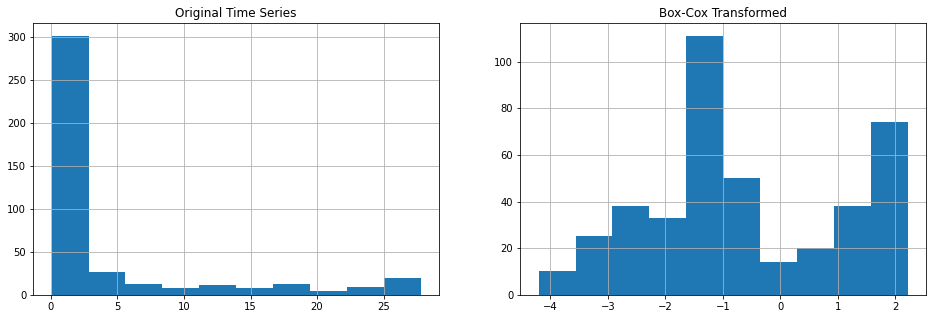

In [326]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
dataset['Open'].hist(ax=ax[0])
ax[0].set_title('Original Time Series')
xts.hist(ax=ax[1])
ax[1].set_title('Box-Cox Transformed')

Text(0.5, 1.0, 'Box-Cox Transformed')

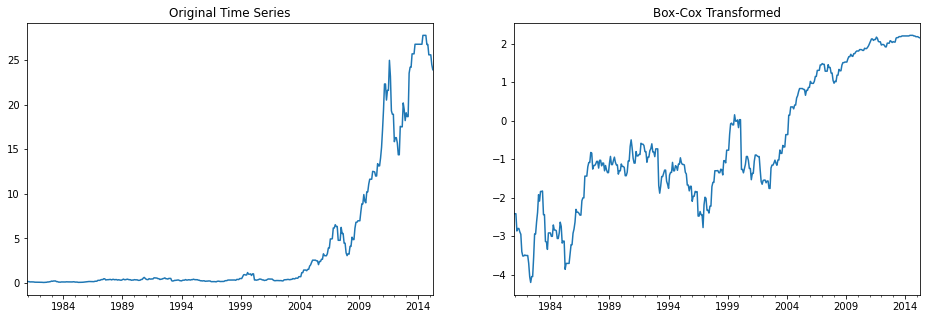

In [327]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
dataset['Open'].plot(ax=ax[0])
ax[0].set_title('Original Time Series')
xts.plot(ax=ax[1])
ax[1].set_title('Box-Cox Transformed')

#### Task 7: Fit a Simple Autoregressive Model

- Fit a simple autoregressive (AR) model (as demonstrated in the notebook) to the transformed and stationary series.
- Validate the model by splitting the data into training and testing sets.
- Evaluate the model's performance using appropriate metrics (e.g., mean squared error, mean absolute error).


In [335]:
(((dataset['Open'] - model.predict())**2).sum())/dataset['Open'].shape[0]

0.3461725843880946

#### Task 8: Test for Autocorrelation and Plot ACF/PACF


- Plot the ACF and PACF to visualize the autocorrelation in the transformed series.
- Interpret the ACF and PACF plots to identify the potential autoregressive (AR) and moving average (MA) components.( optional)


In [337]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

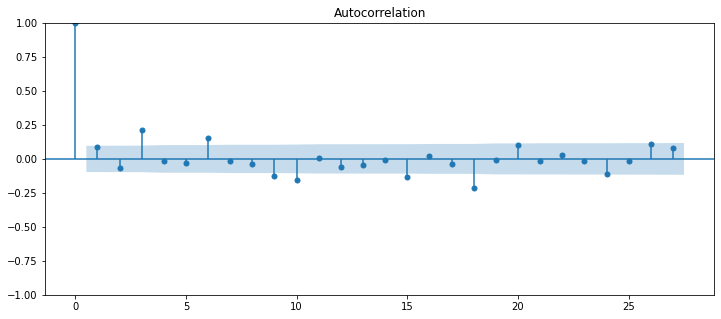

In [338]:
plot_acf(model.resid);plt.show()

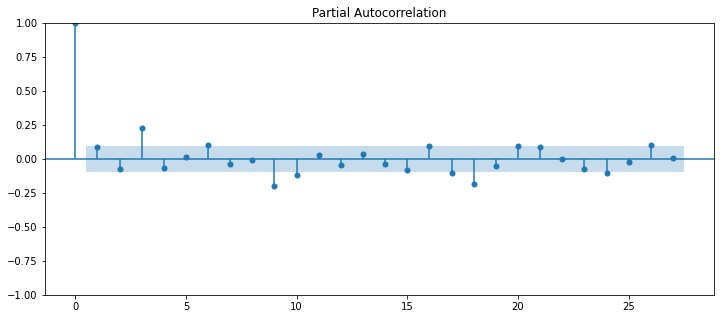

In [340]:
plot_pacf(model.resid);plt.show()

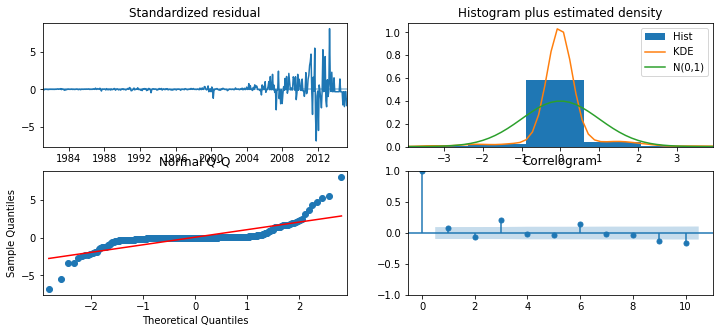

In [339]:
model.plot_diagnostics();plt.show()